In [1]:
from numpy import exp, linspace, zeros, shape, array, roots
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import ipywidgets as widgets
from ipywidgets import FloatSlider, FloatText
from ipywidgets import interact, interactive, fixed
from matplotlib import pyplot as plt
%matplotlib inline

Constants:

In [2]:
R = 8.314 # J/K.mol
T = 298.15 #K, should check this in lab
Cai,  Cbi = 0.08/2, 0.04/2 #Inlet Concentrations
E = 38.6 #kJ/mol

E was obtained from 
https://www.researchgate.net/publication/229360677_Kinetic_Studies_on_Saponification_of_Ethyl_Acetate_Using_an_Innovative_Conductivity-Monitoring_Instrument_with_a_Pulsating_Sensor

In [3]:
def conv(K_i, K, K_f):
    return (K_i - K)/(K_i - K_f)

def CNa_x(x):
    return 0.02*(1-x)

def k0_func(k0, k, E, T): #For use with fsolve!
    return k - k0*exp(-E/(R*10e-3*T))

def k_func(k0, E, T):
    return k0*exp(-E/(R*10e-3*T))

In [4]:
def pfr(var, V, k, n, m, Q):
    Ca, Cb = var
    ra = -k*(Ca**n)*(Cb**m)/Q
    eq1 = ra
    eq2 = ra
    return [eq1, eq2]

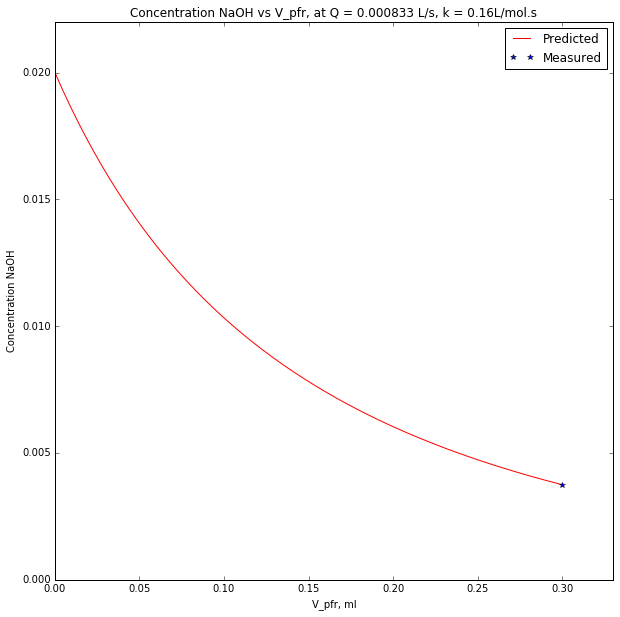

0.8125 Conversion as measured


('Predicted Conversion',
 0.81200000000000006,
 'Residence Time, s',
 360.0,
 'min=',
 6.0)

In [5]:
n_widget = FloatSlider(min=1, max=3, step=1, value=1)
m_widget = FloatSlider(min=1, max=3, step=1, value=1)
k_widget = FloatSlider(min=0.01, max=0.25, step=0.001, value=0.16)

Q_dict = {'24' : 0.024/60, '40' : 0.040/60, '50' : 0.050/60, '60' : 0.060/60} #(ml/min)*(1min/60s)

K_start_widget = FloatText(value = 0.5, description="K start")
K_read_widget = FloatText(value = 0.175, description="K read")
K_final_widget = FloatText(value = 0.1, description="K infinite")

Ca_dict = {'0.04mol/l' : 0.08/2}
Cb_dict = {'0.02mol/l' : 0.04/2}
V_pfr = 0.3 #L

def integration(k, n, m, Q, Cai, Cbi, K_start, K_read, K_final):
    
    tau = round(V_pfr/Q, 2)
    dV = linspace(0, V_pfr, V_pfr*1000+1)
    
    soln_pfr = odeint(pfr, [Cai, Cbi], dV, args=(k, n, m, Q))
    Ca_pfr, Cb_pfr = zip(*soln_pfr)
    conversion_predicted = (Cbi - Cb_pfr[-1])/Cbi
    

    plt.figure(figsize=(10, 10))
    plt.title('Concentration NaOH vs V_pfr, at Q = ' + str(round(Q,6)) + " L/s," + " k = " + str(k) + "L/mol.s")
    plt.xlabel('V_pfr, ml')
    plt.ylabel('Concentration NaOH')
    plt.axis([0, 1.1*V_pfr, 0, 1.1*Cbi])
    conversion_actual = conv(K_start, K_read, K_final) #Conversion equation from notes!
    
    Cb_out = CNa_x(conversion_actual)
    plt.plot(dV, Cb_pfr, 'r-', label='Predicted')
    plt.plot(V_pfr, Cb_out, 'b*', label='Measured')
    plt.legend(loc='best')
    plt.show()
    print(conversion_actual, "Conversion as measured")
    
    plt.figure(figsize=(5, 5))
    
    
    return "Predicted Conversion", round(conversion_predicted, 3), 'Residence Time, s', tau, 'min=', tau/60

interact(integration, k=k_widget, n=n_widget, m=m_widget, Q=Q_dict, Cai=Ca_dict, Cbi=Cb_dict,
         K_start=K_start_widget, K_read=K_read_widget, K_final=K_final_widget)

In [6]:
k = k_widget.value

In [7]:
k0 = fsolve(k0_func, 1, args=(k, E, T))[0]
k0

0.75927719063036636

Batch Reactor Prediction:
Note: k0 is solved for. k_func will return the same k as k_widget.value should T_pfr == T_batch

In [8]:
def batch(var, t, k, n, m):
    Ca, Cb = var
    eq1 = -k*(Ca**n)*(Cb**m)
    eq2 = -k*(Ca**n)*(Cb**m)
    return [eq1, eq2]

In [9]:
batch_time = 15*60#min*60s/min
t_batch = linspace(0, batch_time, batch_time+1)
Cai, Cbi = 0.04, 0.02 #mol/L, devided by 2!

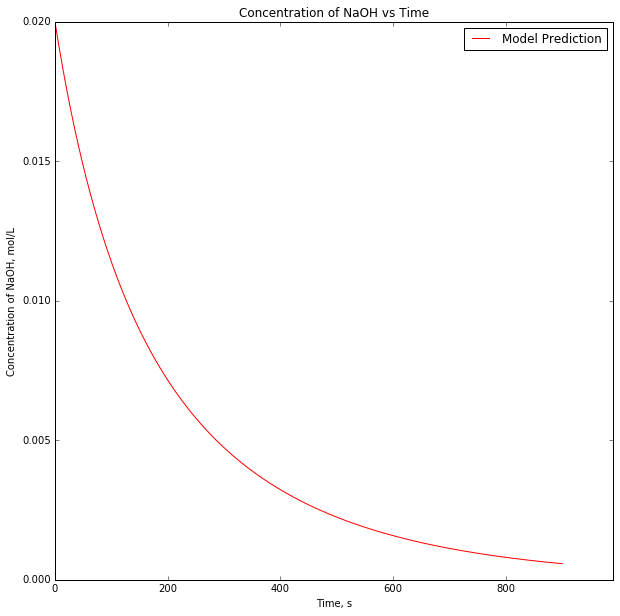

In [10]:
E, T_batch = 38.6, 298.15

if T_batch != T:
    print("A temperature change has been detected! Modifying k value!")
    print("Old k:", k, "New k:", k_func(k0, E, T_batch))
    
Ca_batch, Cb_batch = zip(*odeint(batch, [Cai, Cbi], t_batch, 
                                 args=(k_func(k0, E, T_batch), n_widget.value, m_widget.value)))

plt.figure(figsize=(10, 10))
plt.plot(t_batch, Cb_batch, 'r-', label='Model Prediction')

#plt.plot EXPERIMENTAL DATA

plt.legend(loc='best')
plt.title('Concentration of NaOH vs Time')
plt.xlabel('Time, s')
plt.ylabel('Concentration of NaOH, mol/L')
plt.axis([0, batch_time+0.1*batch_time, 0, 0.02])
plt.show()

Single CSTR: V = 0.3L

Two different inlet flow rates (outlet flow = inlet flow at SS)
Q1 = 0.024L/min
Q2 = 0.040L/min

In [11]:
def cstr(var, V, Q, k, n, m, Cai, Cbi):
    Ca, Cb = var
    eq1 = -k*(Ca**n)*(Cb**m)*V/Q - Ca + Cai
    eq2 = -k*(Ca**n)*(Cb**m)*V/Q - Cb + Cbi
    return [eq1, eq2]

In [12]:
E = 38.6
T_cstr = 298.15

if T_cstr != T:
    print("A temperature change has been detected! Modifying k value!")
    print("Old k:", k, "New k:", k_func(k0, E, T_cstr))
#Q1 = 0.024L/min   
cstr_q1 = fsolve(cstr, [0.002, 0.001],
                      args=(0.300, 0.024/60, k_func(k0, E, T_cstr), n_widget.value, m_widget.value,
                           Cai, Cbi))
tau_q1 = 0.300/(0.024/60)
#Q2 = 0.040L/min
cstr_q2 = fsolve(cstr, [0.002, 0.001],
                      args=(0.300, 0.040/60, k_func(k0, E, T_cstr), n_widget.value, m_widget.value,
                           Cai, Cbi))
tau_q2 = 0.300/(0.040/60)

cstr_q1, cstr_q2

(array([ 0.025,  0.005]), array([ 0.02682301,  0.00682301]))

Two CSTR's in series. V1 = V2 = 150ml

Two different inlet flowrates, Q1=0.024L/min and Q2 = 0.040L/min

In [15]:
E = 38.6
T_cstr_s = 298.15

if T_cstr_s != T:
    print("A temperature change has been detected! Modifying k value!")
    print("Old k:", k, "New k:", k_func(k0, E, T_cstr_s))
    
#Q1 = 0.024L/min
cstr_1_q1 = fsolve(cstr, [0.002, 0.001],
                      args=(0.150, 0.024/60, k_func(k0, E, T_cstr), n_widget.value, m_widget.value,
                           Cai, Cbi))
tau_1_q1 = 0.150/(0.024/60)
cstr_2_q1 = fsolve(cstr, [0.002, 0.001],
                      args=(0.150, 0.024/60, k_func(k0, E, T_cstr), n_widget.value, m_widget.value,
                           cstr_1_q1[0], cstr_1_q1[1]))

conv_q1 = (Cbi - cstr_2_q1[1])/Cbi

#Q2 = 0.040L/min
cstr_1_q2 = fsolve(cstr, [0.002, 0.001],
                      args=(0.150, 0.040/60, k_func(k0, E, T_cstr), n_widget.value, m_widget.value,
                           Cai, Cbi))
tau_1_q2 = 0.150/(0.040/60)
cstr_2_q2 = fsolve(cstr, [0.002, 0.001],
                      args=(0.150, 0.040/60, k_func(k0, E, T_cstr), n_widget.value, m_widget.value,
                           cstr_1_q1[0], cstr_1_q1[1]))

conv_q2 = (Cbi-cstr_2_q2[1])/Cbi



cstr_1_q1, cstr_2_q1, cstr_1_q2, cstr_2_q2, conv_q1, conv_q2

(array([ 0.02754029,  0.00754029]),
 array([ 0.02315579,  0.00315579]),
 array([ 0.02967053,  0.00967053]),
 array([ 0.02404195,  0.00404195]),
 0.84221025706729713,
 0.79790269374386202)

Residence Time Plot

In [16]:
#Recalculate Values for PFR setup. Can't figure out how to get it
#out of the interact object without it clearing it from system memory
V_pfr = 0.3 #L
Q_pfr = [0.024/60, 0.04/60, 0.05/60, 0.06/60]
dV = linspace(0, V_pfr, V_pfr*1000+1)
Cb_pfr = []
tau_pfr = []
for i in Q_pfr:
    C_temp = odeint(pfr, [Cai, Cbi], dV, args=(k, n_widget.value, m_widget.value, i))
    Ca_temp, Cb_temp = zip(*C_temp)
    temp_list = []
    for j in dV:
        temp_list.append(j/i)
    Cb_pfr.append(Cb_temp)
    tau_pfr.append(temp_list)

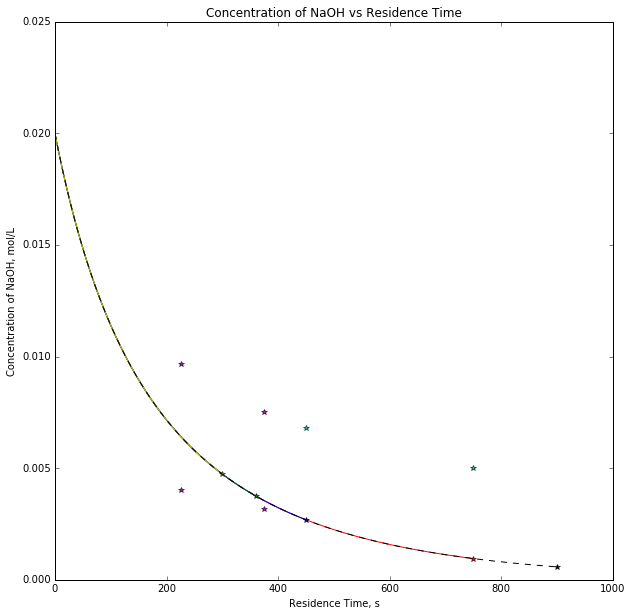

In [17]:
#I haven't done annotations for this plot, as its used ONLY to check
#for consistency in the predictions.
#Since the PFR and BR are synonymous in terms of reaction rate or conversion per residence time,
#and the CSTRs only operate at a rate at outlet conditions,
#the current plot makes sense.
#PFR/BR lines SHOULD be exactly the same, only differing in total residence time
#while CSTRs with a LOWER inlet flow has HIGHER conversion due to HIGHER residence times.
#I'd highly recommend plotting this in excel to make annotations easier and
#making it easier to read.

plt.figure(figsize=(10,10))
plt.title('Concentration of NaOH vs Residence Time')
plt.ylabel('Concentration of NaOH, mol/L')
plt.xlabel('Residence Time, s')
plt.plot(tau_pfr[0], Cb_pfr[0], 'r-', tau_pfr[0][-1], Cb_pfr[0][-1], 'r*')
plt.plot(tau_pfr[1], Cb_pfr[1], 'b-', tau_pfr[1][-1], Cb_pfr[1][-1], 'b*')
plt.plot(tau_pfr[2], Cb_pfr[2], 'g-', tau_pfr[2][-1], Cb_pfr[2][-1], 'g*')
plt.plot(tau_pfr[3], Cb_pfr[3], 'y-', tau_pfr[3][-1], Cb_pfr[3][-1], 'y*')
plt.plot(t_batch, Cb_batch, 'k--', t_batch[-1], Cb_batch[-1], 'k*')
plt.plot(tau_q1, cstr_q1[1], 'c*')
plt.plot(tau_q2, cstr_q2[1], 'c*')
plt.plot(tau_1_q1, cstr_1_q1[1], 'm*', tau_1_q1, cstr_2_q1[1], 'm*')
plt.plot(tau_1_q2, cstr_1_q2[1], 'm*', tau_1_q2, cstr_2_q2[1], 'm*')
plt.axis([0, 1000, 0, 0.025])
plt.show()